In [1]:
pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.3 MB/s eta 0:00:00


Data Preprocessing
Model building
Creating and training K-means model...
Creating and training Isolation Forest model...
Starting data preprocessing...
Extracted features from 37 packets
Preprocessed data shape: (37, 1)
Training autoencoder model...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2873 - val_loss: 1.1146
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.2870 - val_loss: 1.1145
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1.2867 - val_loss: 1.1145
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.2864 - val_loss: 1.1144
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.2861 - val_loss: 1.1144
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.2858 - val_loss: 1.1143
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.2855 - val_loss: 1.1142
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.2852 - val_loss: 1.1142
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.2849 - val_loss: 1.1141
E

Saving trained autoencoder model...
Training K-means model...
Saving trained K-means model...
Training Isolation Forest model...
Saving trained Isolation Forest model...
Evaluating models...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

=== Algorithm Comparison ===

Performance Metrics:
       Algorithm  Anomalies Detected  Accuracy  Precision  Recall  F1 Score  Mean Anomaly Score  Std Dev of Scores  Percentage Above Threshold
     Autoencoder                   1     0.125      1.000   0.125     0.222               1.112              0.769                      12.500
          Kmeans                   1     0.125      1.000   0.125     0.222               0.004              0.012                      12.500
Isolation Forest                   1     0.125      1.000   0.125     0.222              -0.028              0.018                      12.500


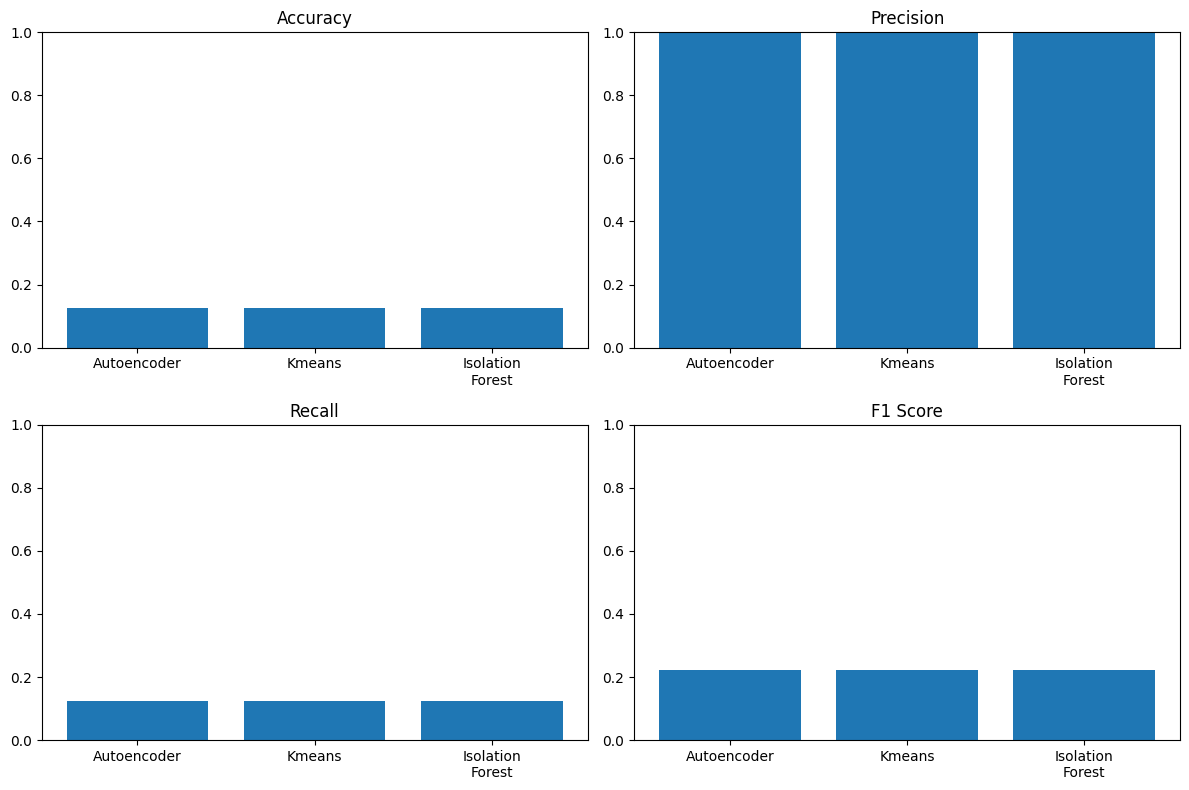


Confusion Matrices:

Autoencoder:
                Predicted Normal  Predicted Anomaly
Actual Normal                  0                  0
Actual Anomaly                 7                  1

Kmeans:
                Predicted Normal  Predicted Anomaly
Actual Normal                  0                  0
Actual Anomaly                 7                  1

Isolation Forest:
                Predicted Normal  Predicted Anomaly
Actual Normal                  0                  0
Actual Anomaly                 7                  1

Algorithm Agreement:
Percentage agreement in anomaly detection:
                 autoencoder  kmeans isolation_forest
autoencoder           100.0%  100.0%           100.0%
kmeans                100.0%  100.0%           100.0%
isolation_forest      100.0%  100.0%           100.0%

Ensemble Performance:
Accuracy: 0.125
Precision: 1.000
Recall: 0.125
F1 Score: 0.222
Anomalies detected: 1

Ensemble vs Individual Algorithms:
Ensemble anomalies covered by Autoencoder: 1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scapy.all import *
import socket
import struct
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

file_path = "NMRL demo packets.txt"

# ------------------ DATA PREPROCESSING -------------------
print("Data Preprocessing")

scaler = StandardScaler()
def extract_packet_features(packet_hex):
    """
    Parse a single packet in hex format and extract relevant features
    Args:
        packet_hex (str): Raw hexadecimal packet data
    Returns:
        dict: Dictionary of extracted features
    """
    features = {}
    scaler = StandardScaler()

    # Clean up the packet data (remove separators and newlines)
    packet_data = ''.join(packet_hex.replace('|', '').replace('\n', '').split())

    # Basic packet size
    features['packet_size'] = len(packet_data) // 2  # Convert from hex chars to bytes

    # Extract Ethernet header (first 14 bytes = 28 hex chars)
    if len(packet_data) >= 28:
        eth_header = packet_data[:28]

        # Source and destination MAC addresses
        features['dst_mac'] = eth_header[:12]
        features['src_mac'] = eth_header[12:24]

        # Ethernet type
        features['eth_type'] = eth_header[24:28]

        # Check for IP packet (0800 = IPv4)
        if features['eth_type'] == '0800' and len(packet_data) >= 52:
            # Parse IP header
            ip_header = packet_data[28:68]  # 20 bytes = 40 hex chars

            # Extract IP header length (IHL)
            ihl = int(ip_header[1], 16) & 0x0F
            ip_header_length = ihl * 4  # in bytes

            # Protocol (TCP=6, UDP=17, ICMP=1)
            features['protocol'] = int(ip_header[18:20], 16)

            # Source and destination IP addresses
            src_ip_hex = ip_header[24:32]
            dst_ip_hex = ip_header[32:40]

            # Convert hex IP to dotted decimal
            features['src_ip'] = '.'.join(str(int(src_ip_hex[i:i+2], 16)) for i in range(0, 8, 2))
            features['dst_ip'] = '.'.join(str(int(dst_ip_hex[i:i+2], 16)) for i in range(0, 8, 2))

            # Position where the transport layer (TCP/UDP) header starts
            transport_offset = 28 + (ip_header_length * 2)  # Converting bytes to hex chars

            # Check if we have TCP
            if features['protocol'] == 6 and len(packet_data) >= transport_offset + 8:
                tcp_header = packet_data[transport_offset:transport_offset+40]  # 20 bytes = 40 hex chars

                # Extract source and destination ports
                features['src_port'] = int(tcp_header[:4], 16)
                features['dst_port'] = int(tcp_header[4:8], 16)

                # TCP flags
                if len(tcp_header) >= 26:
                    flags = int(tcp_header[24:26], 16)
                    features['tcp_fin'] = (flags & 0x01) > 0
                    features['tcp_syn'] = (flags & 0x02) > 0
                    features['tcp_rst'] = (flags & 0x04) > 0
                    features['tcp_psh'] = (flags & 0x08) > 0
                    features['tcp_ack'] = (flags & 0x10) > 0
                    features['tcp_urg'] = (flags & 0x20) > 0

            # Check if we have UDP
            elif features['protocol'] == 17 and len(packet_data) >= transport_offset + 8:
                udp_header = packet_data[transport_offset:transport_offset+16]  # 8 bytes = 16 hex chars

                # Extract source and destination ports
                features['src_port'] = int(udp_header[:4], 16)
                features['dst_port'] = int(udp_header[4:8], 16)

                # UDP length
                features['udp_length'] = int(udp_header[8:12], 16)

        # Check for IPv6 packet (86DD = IPv6)
        elif features['eth_type'] == '86dd' and len(packet_data) >= 88:
            # Parse IPv6 header (40 bytes = 80 hex chars)
            ipv6_header = packet_data[28:108]

            # Next header (similar to protocol in IPv4)
            features['protocol'] = int(ipv6_header[12:14], 16)

            # Source and destination IPv6 addresses
            features['src_ipv6'] = ipv6_header[16:48]
            features['dst_ipv6'] = ipv6_header[48:80]

            # Position where the transport layer header starts (fixed for IPv6)
            transport_offset = 28 + 80  # 40 bytes = 80 hex chars

            # Check if we have TCP
            if features['protocol'] == 6 and len(packet_data) >= transport_offset + 8:
                tcp_header = packet_data[transport_offset:transport_offset+40]

                # Extract source and destination ports
                features['src_port'] = int(tcp_header[:4], 16)
                features['dst_port'] = int(tcp_header[4:8], 16)

            # Check if we have UDP
            elif features['protocol'] == 17 and len(packet_data) >= transport_offset + 8:
                udp_header = packet_data[transport_offset:transport_offset+16]

                # Extract source and destination ports
                features['src_port'] = int(udp_header[:4], 16)
                features['dst_port'] = int(udp_header[4:8], 16)

    return features

def extract_timestamp(timestamp_str):
    """
    Extract and convert timestamp from packet data
    Args:
        timestamp_str (str): Timestamp string from packet
    Returns:
        float: Timestamp as a float
    """
    try:
        # Parse timestamp in format HH:MM:SS,milliseconds
        match = re.match(r'(\d+):(\d+):(\d+),(\d+)', timestamp_str)
        if match:
            hours, minutes, seconds, milliseconds = map(int, match.groups())
            return hours * 3600 + minutes * 60 + seconds + milliseconds / 1000.0
        return 0
    except:
        return 0


def parse_packet_file(file_path):
    """
    Parse a file containing packet data and extract features
    Args:
        file_path (str): Path to the packet data file
    Returns:
        list: List of packet feature dictionaries
    """
    packets = []
    current_packet = ""
    timestamp = ""

    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

            i = 0
            while i < len(lines):
                line = lines[i].strip()

                # Check if this is a separator line indicating a new packet
                if line.startswith('+---------+'):
                    # If we have collected a packet, process it
                    if current_packet and timestamp:
                        features = extract_packet_features(current_packet)
                        features['timestamp'] = extract_timestamp(timestamp)
                        packets.append(features)

                    # Reset for next packet
                    current_packet = ""

                    # The next line should have the timestamp
                    if i + 1 < len(lines):
                        timestamp_line = lines[i + 1].strip()
                        timestamp_match = re.search(r'(\d+:\d+:\d+,\d+)', timestamp_line)
                        if timestamp_match:
                            timestamp = timestamp_match.group(1)
                        i += 1  # Skip the timestamp line

                # If this is part of the packet data, collect it
                elif line and not line.startswith('+---------+'):
                    current_packet += line + "\n"

                i += 1

            # Process the last packet if there is one
            if current_packet and timestamp:
                features = extract_packet_features(current_packet)
                features['timestamp'] = extract_timestamp(timestamp)
                packets.append(features)

    except Exception as e:
        print(f"Error parsing packet file: {e}")

    return packets

def preprocess_features(packets):
    """
    Convert the list of packet features into a pandas DataFrame
    and prepare it for machine learning
    Args:
        packets (list): List of packet feature dictionaries
    Returns:
        tuple: (DataFrame with features, feature names)
    """
    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(packets)

    # Fill missing values
    df = df.fillna(0)

    # Convert boolean columns to integers
    for col in df.columns:
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)

    # Create numerical features only DataFrame for machine learning
    feature_cols = []

    # Select only numerical columns for modeling
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) and col != 'timestamp':
            feature_cols.append(col)

    # Create feature matrix
    X = df[feature_cols].copy()

    X_scaled = scaler.fit_transform(X)

    # Save the scaler for later use
    joblib.dump(scaler, 'scaler.pkl')

    return X_scaled, df, feature_cols

# ------------------ MODEL BUILDING -------------------
print("Model building")
def build_autoencoder(input_dim):
    """
    Build an autoencoder model for anomaly detection
    Args:
        input_dim (int): Number of input features
    Returns:
        tuple: (autoencoder model, encoder part)
    """
    # Define the encoding dimension
    encoding_dim = min(max(int(input_dim * 0.75), 5), input_dim - 1)

    # Define the input layer
    input_layer = Input(shape=(input_dim,))

    # Define the encoder layers
    encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Define the decoder layers
    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Define the autoencoder model
    autoencoder = Model(input_layer, decoded)

    # Define the encoder model
    encoder = Model(input_layer, encoded)

    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder, encoder

def train_autoencoder(X_train, X_val=None, epochs=50, batch_size=32):
    """Train the autoencoder model"""
    # Build the autoencoder
    autoencoder, encoder = build_autoencoder(X_train.shape[1])

    # Prepare validation data
    validation_data = None
    if X_val is not None:
        validation_data = (X_val, X_val)

    # Train the autoencoder
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=validation_data,
        verbose=1
    )

    # Get reconstruction error on training data
    predictions = autoencoder.predict(X_train)
    mse = np.mean(np.power(X_train - predictions, 2), axis=1)

    # Save the models
    print("Saving trained autoencoder model...")
    save_model(autoencoder, 'autoencoder_model.h5')
    save_model(encoder, 'encoder_model.h5')

    # Save the reconstruction error threshold
    threshold = np.percentile(mse, 95)
    with open('autoencoder_threshold.pkl', 'wb') as f:
        pickle.dump(threshold, f)

    return autoencoder, encoder, mse, threshold

print("Creating and training K-means model...")
def train_kmeans(X_train, n_clusters=5):
    """
    Train K-means clustering model
    Args:
        X_train: Training data
        n_clusters: Number of clusters
    Returns:
        KMeans: Trained K-means model
    """
    # Create and train K-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    print("Saving trained K-means model...")
    joblib.dump(kmeans, 'kmeans_model.pkl')
    return kmeans

print("Creating and training Isolation Forest model...")
def train_isolation_forest(X_train):
    """
    Train Isolation Forest model for anomaly detection
    Args:
        X_train: Training data
    Returns:
        IsolationForest: Trained Isolation Forest model
    """
    # Create and train Isolation Forest model
    isolation_forest = IsolationForest(contamination=0.05, random_state=42)
    isolation_forest.fit(X_train)
    print("Saving trained Isolation Forest model...")
    joblib.dump(isolation_forest, 'isolation_forest_model.pkl')
    return isolation_forest

def evaluate_models(X_test, autoencoder, kmeans, isolation_forest, autoencoder_threshold):
    """
    Evaluate all models on test data
    Args:
        X_test: Test data
        autoencoder: Trained autoencoder model
        kmeans: Trained K-means model
        isolation_forest: Trained Isolation Forest model
        autoencoder_threshold: Threshold for autoencoder anomaly detection
    Returns:
        dict: Dictionary with model evaluation results
    """
    results = {}

    # Evaluate autoencoder
    predictions = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    results['autoencoder_anomalies'] = mse > autoencoder_threshold
    results['autoencoder_scores'] = mse

    # Evaluate K-means
    distances = np.min(
        [np.linalg.norm(X_test - kmeans.cluster_centers_[i], axis=1) for i in range(kmeans.n_clusters)],
        axis=0
    )
    kmeans_threshold = np.percentile(distances, 95)
    results['kmeans_anomalies'] = distances > kmeans_threshold
    results['kmeans_scores'] = distances
    results['kmeans_clusters'] = kmeans.predict(X_test)

    # Save the K-means threshold
    with open('kmeans_threshold.pkl', 'wb') as f:
        pickle.dump(kmeans_threshold, f)

    # Evaluate Isolation Forest
    if_predictions = isolation_forest.predict(X_test)
    if_scores = isolation_forest.decision_function(X_test)
    results['isolation_forest_anomalies'] = if_predictions == -1
    results['isolation_forest_scores'] = -if_scores  # Negate to make higher values more anomalous

    # Since this is unsupervised, we'll assume anomalies are the top 5% of scores
    # This is just for demonstration - in a real scenario you'd need labeled data
    y_true = np.zeros(len(X_test))
    num_anomalies = int(0.05 * len(X_test))
    y_true[np.argsort(results['autoencoder_scores'])[-num_anomalies:]] = 1

    # Calculate metrics for each algorithm
    for algo in ['autoencoder', 'kmeans', 'isolation_forest']:
        y_pred = results[f'{algo}_anomalies']

        # Calculate metrics
        results[f'{algo}_accuracy'] = accuracy_score(y_true, y_pred)
        results[f'{algo}_precision'] = precision_score(y_true, y_pred)
        results[f'{algo}_recall'] = recall_score(y_true, y_pred)
        results[f'{algo}_f1'] = f1_score(y_true, y_pred)
        results[f'{algo}_confusion_matrix'] = confusion_matrix(y_true, y_pred)

    return results

def compare_algorithms(results, X_test):
    """
    Compare the performance of the different anomaly detection algorithms
    Args:
        results: Dictionary containing the evaluation results from evaluate_models()
        X_test: Test data used for evaluation
    """
    print("\n=== Algorithm Comparison ===")

    # Calculate basic statistics for each algorithm
    algorithms = ['autoencoder', 'kmeans', 'isolation_forest']

    # Create a dictionary to store comparison metrics
    comparison = {
        'Algorithm': [],
        'Anomalies Detected': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Mean Anomaly Score': [],
        'Std Dev of Scores': [],
        'Percentage Above Threshold': []
    }

    for algo in algorithms:
        scores = results[f'{algo}_scores']
        anomalies = results[f'{algo}_anomalies']

        comparison['Algorithm'].append(algo.replace('_', ' ').title())
        comparison['Anomalies Detected'].append(np.sum(anomalies))
        comparison['Accuracy'].append(results[f'{algo}_accuracy'])
        comparison['Precision'].append(results[f'{algo}_precision'])
        comparison['Recall'].append(results[f'{algo}_recall'])
        comparison['F1 Score'].append(results[f'{algo}_f1'])
        comparison['Mean Anomaly Score'].append(np.mean(scores))
        comparison['Std Dev of Scores'].append(np.std(scores))
        comparison['Percentage Above Threshold'].append(
            np.sum(anomalies) / len(X_test) * 100
        )

    # Create a DataFrame for nice display
    comparison_df = pd.DataFrame(comparison)
    print("\nPerformance Metrics:")
    print(comparison_df.to_string(index=False, float_format="%.3f"))

    # Plot comparison of metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.bar([algo.replace('_', '\n').title() for algo in algorithms],
                [results[f'{algo}_{metric.lower().replace(" ", "_")}'.replace("_score", "")] for algo in algorithms]) # Access metric values with the correct keys, e.g., 'autoencoder_accuracy', 'autoencoder_precision', etc.
        plt.title(metric)
        plt.title(metric)
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig('algorithm_metrics_comparison.png')
    plt.show()

    # Print confusion matrices
    print("\nConfusion Matrices:")
    for algo in algorithms:
        print(f"\n{algo.replace('_', ' ').title()}:")
        print(pd.DataFrame(
            results[f'{algo}_confusion_matrix'],
            columns=['Predicted Normal', 'Predicted Anomaly'],
            index=['Actual Normal', 'Actual Anomaly']
        ))

    # Calculate agreement between algorithms
    print("\nAlgorithm Agreement:")
    agreements = pd.DataFrame(index=algorithms, columns=algorithms)
    for algo1 in algorithms:
        for algo2 in algorithms:
            agreement = np.mean(
                results[f'{algo1}_anomalies'] == results[f'{algo2}_anomalies']
            ) * 100
            agreements.loc[algo1, algo2] = f"{agreement:.1f}%"

    print("Percentage agreement in anomaly detection:")
    print(agreements)

    # Get y_true from results (created in evaluate_models)
    y_true = np.zeros(len(X_test))
    num_anomalies = int(0.05 * len(X_test))
    y_true[np.argsort(results['autoencoder_scores'])[-num_anomalies:]] = 1

    # Ensemble performance (majority voting)
    ensemble_anomalies = (
        results['autoencoder_anomalies'].astype(int) +
        results['kmeans_anomalies'].astype(int) +
        results['isolation_forest_anomalies'].astype(int)
    ) >= 2

    # Calculate ensemble metrics
    ensemble_accuracy = accuracy_score(y_true, ensemble_anomalies)
    ensemble_precision = precision_score(y_true, ensemble_anomalies)
    ensemble_recall = recall_score(y_true, ensemble_anomalies)
    ensemble_f1 = f1_score(y_true, ensemble_anomalies)

    print(f"\nEnsemble Performance:")
    print(f"Accuracy: {ensemble_accuracy:.3f}")
    print(f"Precision: {ensemble_precision:.3f}")
    print(f"Recall: {ensemble_recall:.3f}")
    print(f"F1 Score: {ensemble_f1:.3f}")
    print(f"Anomalies detected: {np.sum(ensemble_anomalies)}")

    # Compare with individual algorithms
    print("\nEnsemble vs Individual Algorithms:")
    for algo in algorithms:
        overlap = np.mean(
            ensemble_anomalies & results[f'{algo}_anomalies']
        ) / np.mean(ensemble_anomalies) * 100
        print(f"Ensemble anomalies covered by {algo.replace('_', ' ').title()}: {overlap:.1f}%")

def detect_anomalies_real_time(packet_data, scaler, autoencoder, autoencoder_threshold,
                              kmeans, kmeans_threshold, isolation_forest, feature_cols, df):
    """
    Detect anomalies in real-time network packets
    Args:
        packet_data: Raw packet data
        scaler: Trained StandardScaler
        autoencoder: Trained autoencoder model
        autoencoder_threshold: Threshold for autoencoder anomaly detection
        kmeans: Trained K-means model
        kmeans_threshold: Threshold for K-means anomaly detection
        isolation_forest: Trained Isolation Forest model
        feature_cols: List of feature column names
        df: DataFrame with training data
    Returns:
        dict: Dictionary with anomaly detection results
    """
    # Extract features from the packet
    features = extract_packet_features(packet_data)

    # If essential features are missing, return no anomaly
    if not features:
        return {
            'autoencoder': False,
            'kmeans': False,
            'isolation_forest': False,
            'ensemble': False,
            'scores': {
                'autoencoder': 0,
                'kmeans': 0,
                'isolation_forest': 0
            }
        }

    # Prepare features similar to training data
    feature_vector = []
    for col in feature_cols:
        feature_vector.append(features.get(col, 0))

    # Convert to numpy array and reshape
    X = np.array(feature_vector).reshape(1, -1)

    # Scale the features
    X_scaled = scaler.transform(X)
    X_scaled = scaler.fit_transform(df)

    # Autoencoder prediction
    ae_pred = autoencoder.predict(X_scaled)
    ae_mse = np.mean(np.power(X_scaled - ae_pred, 2), axis=1)[0]
    ae_anomaly = ae_mse > autoencoder_threshold

    # K-means prediction
    distances = np.min(
        [np.linalg.norm(X_scaled - kmeans.cluster_centers_[i], axis=1) for i in range(kmeans.n_clusters)],
        axis=0
    )[0]
    km_anomaly = distances > kmeans_threshold

    # Isolation Forest prediction
    if_prediction = isolation_forest.predict(X_scaled)[0]
    if_score = -isolation_forest.decision_function(X_scaled)[0]
    if_anomaly = if_prediction == -1

    # Ensemble decision (majority voting)
    ensemble_anomaly = (ae_anomaly + km_anomaly + if_anomaly) >= 2

    return {
        'autoencoder': bool(ae_anomaly),
        'kmeans': bool(km_anomaly),
        'isolation_forest': bool(if_anomaly),
        'ensemble': bool(ensemble_anomaly),
        'scores': {
            'autoencoder': float(ae_mse),
            'kmeans': float(distances),
            'isolation_forest': float(if_score)
        }
    }

def sniff_packets_and_detect(interface='eth0', count=None, feature_cols=None, df=None):
    """
    Sniff network packets and detect anomalies in real-time
    Args:
        interface: Network interface to sniff
        count: Number of packets to sniff (None for indefinite)
        feature_cols: List of feature column names
    """
    # Load models and thresholds
    scaler = joblib.load('scaler.pkl')
    autoencoder = load_model('autoencoder_model.h5')
    with open('autoencoder_threshold.pkl', 'rb') as f:
        autoencoder_threshold = pickle.load(f)
    kmeans = joblib.load('kmeans_model.pkl')
    with open('kmeans_threshold.pkl', 'rb') as f:
        kmeans_threshold = pickle.load(f)
    isolation_forest = joblib.load('isolation_forest_model.pkl')

    def packet_callback(packet):
        # Convert packet to hex format
        packet_hex = packet.build().hex()

        # Format packet_hex similar to our training data
        formatted_packet = '|'.join(packet_hex[i:i+2] for i in range(0, len(packet_hex), 2))

        # Detect anomalies
        result = detect_anomalies_real_time(
            formatted_packet, scaler, autoencoder, autoencoder_threshold,
            kmeans, kmeans_threshold, isolation_forest, feature_cols, df
        )

        # If an ensemble anomaly is detected, alert
        if result['ensemble']:
            print(f"⚠️ ANOMALY DETECTED: {result}")
        else:
            print(f"Normal traffic: {result['scores']}")

        return True

    # Start sniffing
    print(f"Starting packet capture on interface {interface}...")
    sniff(iface=interface, prn=packet_callback, count=count, store=0)

# ------------------ MAIN EXECUTION -------------------
if __name__ == "__main__":
    # File path to packet data
    file_path = "NMRL demo packets.txt"

    print("Starting data preprocessing...")

    # Parse packet file and extract features
    packets = parse_packet_file(file_path)
    print(f"Extracted features from {len(packets)} packets")

    # Preprocess features
    X_scaled, df, feature_cols = preprocess_features(packets)
    print(f"Preprocessed data shape: {X_scaled.shape}")

    # Split data for training and testing
    X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

    # Train models and save them
    print("Training autoencoder model...")
    autoencoder, encoder, mse, autoencoder_threshold = train_autoencoder(X_train, X_val=X_test)

    print("Training K-means model...")
    kmeans = train_kmeans(X_train)

    print("Training Isolation Forest model...")
    isolation_forest = train_isolation_forest(X_train)

    # Evaluate models
    print("Evaluating models...")
    results = evaluate_models(X_test, autoencoder, kmeans, isolation_forest, autoencoder_threshold)

    # Compare algorithms
    compare_algorithms(results, X_test)

    print("Model training and evaluation complete!")
    print("All models saved to working directory.")

    # Start real-time anomaly detection
    print("\nStarting real-time anomaly detection...")
    try:
        sniff_packets_and_detect(interface='eth0', count=100, feature_cols=feature_cols, df=df)
    except Exception as e:
        print(f"Error in real-time detection: {e}")